k-NN Classifier
This notebook implements a k-NN classifier to predict weekly stock labels using mean return (µ) and volatility (σ). We follow these steps:
1. **Train k-NN on Years 1-3** and evaluate different values of \( k \).
2. **Select the best \( k \)** and use it to classify Years 4-5.
3. **Compute accuracy and confusion matrix for testing years.**
4. **Compute sensitivity and specificity.**
5. **Compare a trading strategy using k-NN predictions vs. Buy-and-Hold.**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import files  # For manual file upload


In [3]:
# Upload the CSV file manually in Colab
uploaded = files.upload()

# Get file name
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Display first few rows
df.head()

Saving Processed_Stock_Data.csv to Processed_Stock_Data.csv


,Year,Week_Number,mean_return,volatility,Label
0,2020,0,-80.05,113.21,Red
1,2020,1,69.02,44.37,Green
2,2020,2,41.74,192.39,Green
3,2020,3,12.40,101.47,Green
4,2020,4,-111.10,302.78,Red


In [4]:
# Splitting dataset into training (Years 1-3) and testing (Years 4-5)
train_years = [2020, 2021, 2022]
test_years = [2023, 2024]

train_df = df[df['Year'].isin(train_years)].copy()
test_df = df[df['Year'].isin(test_years)].copy()

# Extract features (µ, σ) and labels
X_train = train_df[['mean_return', 'volatility']]
y_train = train_df['Label']
X_test = test_df[['mean_return', 'volatility']]
y_test = test_df['Label']

# Display dataset sizes
len(X_train), len(X_test)

(157, 105)

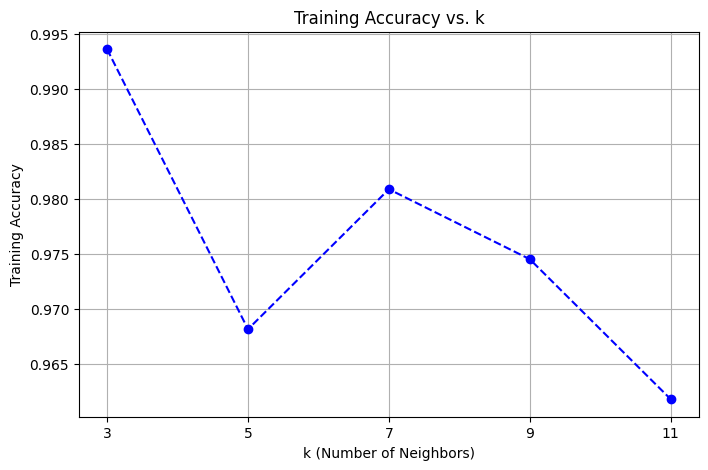

Optimal k: 3


In [5]:
# Evaluating k-NN for different k values
k_values = [3, 5, 7, 9, 11]
train_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(accuracy)

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_accuracies, marker='o', linestyle='dashed', color='b')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Find the best k
optimal_k = k_values[train_accuracies.index(max(train_accuracies))]
print(f'Optimal k: {optimal_k}')

In [6]:
# Train k-NN with the optimal k and test on unseen data
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_test_pred = knn_optimal.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2%}')

Test Accuracy: 96.19%


In [7]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=['Green', 'Red'])
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['Actual Green', 'Actual Red'],
                              columns=['Predicted Green', 'Predicted Red'])
conf_matrix_df

,Predicted Green,Predicted Red
Actual Green,43,3
Actual Red,1,58


In [8]:
# Compute Sensitivity (Recall) and Specificity
TP = conf_matrix[0, 0]  # True Positives
FN = conf_matrix[0, 1]  # False Negatives
TN = conf_matrix[1, 1]  # True Negatives
FP = conf_matrix[1, 0]  # False Positives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity (Recall): {sensitivity:.2%}')
print(f'Specificity: {specificity:.2%}')

Sensitivity (Recall): 93.48%
Specificity: 98.31%


In [9]:
# Simulate investment strategy using k-NN labels
initial_investment = 100
portfolio_results = []

for year in test_years:
    df_year = test_df[test_df['Year'] == year]
    strategy_balance = initial_investment
    buy_hold_balance = initial_investment

    for i, row in df_year.iterrows():
        weekly_return = row['mean_return'] / 100
        weekly_return = max(min(weekly_return, 0.5), -0.5)
        buy_hold_balance *= (1 + weekly_return)
        if row['Label'] == 'Green':
            strategy_balance *= (1 + weekly_return)

    portfolio_results.append({
        'Year': year,
        'Strategy Growth ($)': round(strategy_balance, 2),
        'Buy & Hold Growth ($)': round(buy_hold_balance, 2)
    })

portfolio_growth_df = pd.DataFrame(portfolio_results)
portfolio_growth_df

,Year,Strategy Growth ($),Buy & Hold Growth ($)
0,2023,356869.78,1922.37
1,2024,482501.14,535.47
